In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows',None)

warnings.filterwarnings('ignore')

In [4]:
def quick_check(data):
    data_nulls = data.isna().sum()
    total_rows = len(data)
    
    nulls_dict = {}
    
    for column, count in data_nulls.items():
        if count > 0:
            percentage = round((count / total_rows) * 100, 1)
            nulls_dict[column] = percentage
    
    Table = pd.DataFrame.from_dict(nulls_dict, orient='index', columns=['Percentage Missing'])
    return Table

In [5]:
def really_cat(cat_cols):
    lis=[]
    li2=[]
    for i,column in enumerate(cat_cols):
        if len(cat_cols[column].unique()) < 20:
            lis.append(column)
        else:
            li2.append(column)
    return lis
        

In [6]:
def categorize_cols(data):
    numeric = data.select_dtypes(include=[np.number])
    categorical = data.select_dtypes(include = object)
    return numeric,categorical

In [7]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [8]:
display(train.head(8))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
num_cols,cat_cols = categorize_cols(train)
confirm_cat = really_cat(num_cols)
for i in confirm_cat:
    print(i,train[i].unique())


MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0 1 2]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces [0 1 2 3]
GarageCars [2 3 1 0 4]
PoolArea [  0 512 648 576 555 480 519 738]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold [2008 2007 2006 2009 2010]


In [11]:
to_conv = ["MSSubClass","OverallQual","OverallCond","MoSold","YrSold"]
train[to_conv] = train[to_conv].astype(object)

In [12]:
quick_check(train)

,Percentage Missing
LotFrontage,17.7
Alley,93.8
MasVnrType,59.7
MasVnrArea,0.5
BsmtQual,2.5
BsmtCond,2.5
BsmtExposure,2.6
BsmtFinType1,2.5
BsmtFinType2,2.6
Electrical,0.1


In [13]:
missing = quick_check(train)
to_cut = missing[missing['Percentage Missing']>6]
to_drop=list(to_cut.index)
train = train.drop(to_drop+['Id'],axis=1)

<Axes: >

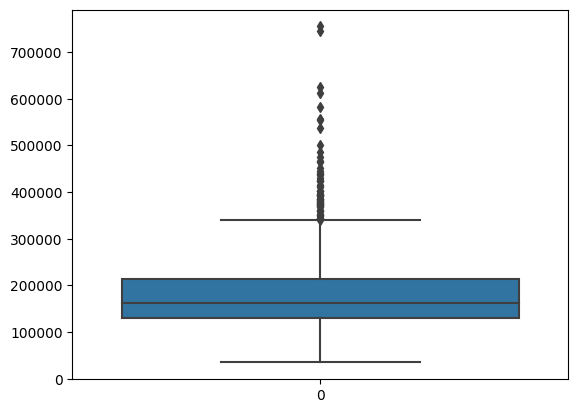

In [14]:
sns.boxplot(data=train['SalePrice'])

In [15]:
Q1 = train['SalePrice'].quantile(0.25)
Q3 = train['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define a threshold for identifying outliers
# Commonly, a common threshold is 1.5 times the IQR
threshold = 1.5

# Step 3: Identify outliers
# Outliers are the data points that fall below Q1 - threshold * IQR or above Q3 + threshold * IQR
outliers = train[(train['SalePrice'] < Q1 - threshold * IQR) | (train['SalePrice'] > Q3 + threshold * IQR)]
train = train.drop(outliers.index)

In [16]:
train = train.dropna()
train.shape

(1278, 73)

In [17]:
num_cols,cat_cols = categorize_cols(train)
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for i,col in enumerate(cat_cols):
    train[col] = label.fit_transform(train[col])

In [18]:
x = train.drop(['SalePrice'],axis=1)
filterr = x.columns
y = train['SalePrice']
y = np.ravel(y)

In [19]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor 
n_features_to_select=50
lr = DecisionTreeRegressor()
rfe = RFE(estimator=lr,n_features_to_select = n_features_to_select)
rfe.fit(x,y)
selected = filterr[rfe.get_support()]
rank = rfe.ranking_
dictt = {k: v for k, v in zip(selected, rank)}


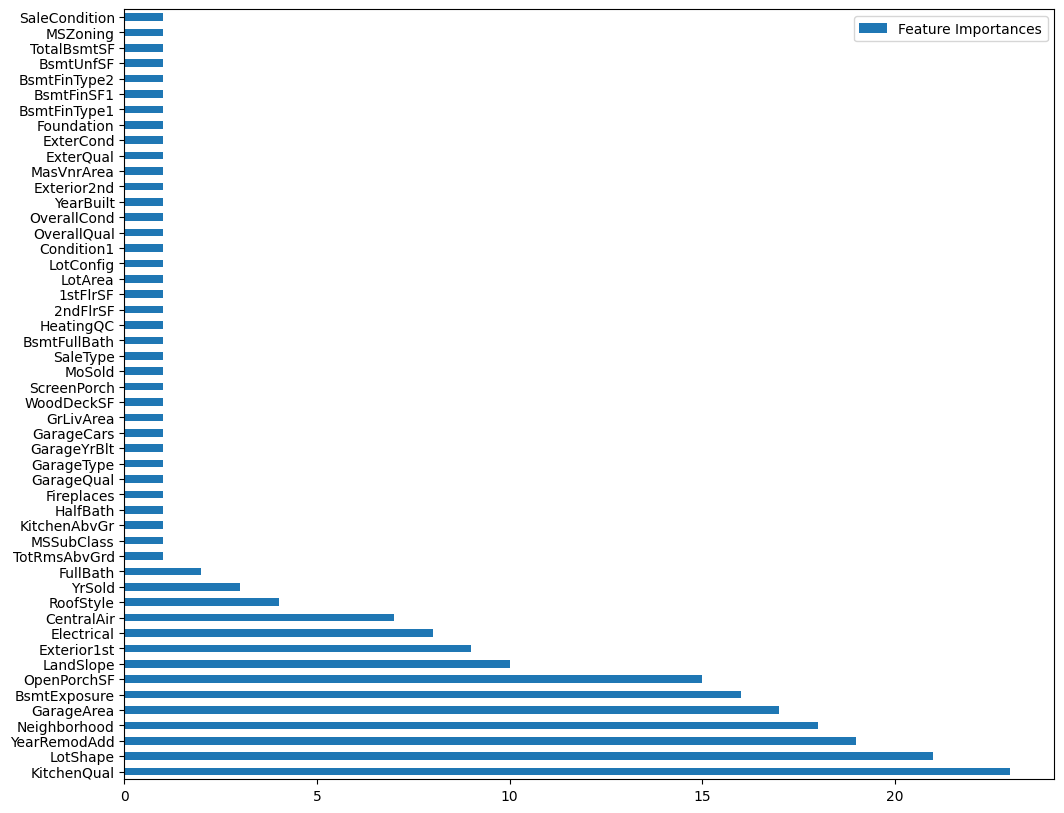

In [20]:
rank = rfe.ranking_
dictt = {k: v for k, v in zip(selected, rank)}
imp_df = pd.DataFrame.from_dict(dictt,orient='index',columns=['Feature Importances'])
imp_df.sort_values('Feature Importances',ascending=False).plot(kind='barh')
plt.gcf().set_size_inches(12,10)

In [21]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = train[selected]
x = scale.fit_transform(x)

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=55)
print(x_train.shape,y_train.shape)

(894, 50) (894,)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Create and fit the linear regression model
l = LinearRegression()
l.fit(x_train, y_train)

# Make predictions on the test data
y_pred = l.predict(x_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

26887.965151728316


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

clf = DecisionTreeRegressor(random_state=45)

# Define a grid of hyperparameters to search
param_grid = {
    'criterion': ['poisson','squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 3,5,6,8],
    'min_samples_split': [2,4,6],
    'min_samples_leaf':[1,2,4,6,7],# Adjust the values as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=3,scoring='neg_root_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
r2_score = best_model.score(x_test, y_test)

print("Best R-squared Score:", r2_score)


Best R-squared Score: 0.7591676679883953


In [25]:
c = best_model.predict(x_test)
z = np.mean(abs((y_test-c)/y_test)*100)
print(z)
rmse = np.sqrt(mean_squared_error(y_test, c))
print(rmse)

12.666940463183641
28431.219109894206


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'max_depth': [3, 5, 6, 8],
    'subsample': [0.5, 0.7, 1],  # Fix the typo here
    'lambda': [1, 6, 10],
    'alpha': [1, 6, 10],
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror', 'reg:absoluteerror', 'reg:quantileerror', '']
    # Adjust the values as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
r2_score = best_model.score(x_test, y_test)

print("Best R-squared Score:", r2_score)


[09:43:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[09:43:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.



In [27]:
model = grid_search.best_estimator_

In [28]:
model

XGBRegressor(alpha=6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=6, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

In [29]:
pred = model.predict(x_test)
mape = np.mean(abs(((y_test - pred)/y_test)*100))

In [30]:
mape

10.209998564163392

In [31]:
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
t = test

In [32]:
missing = quick_check(test)
to_cut = missing[missing['Percentage Missing']>6]
to_drop=list(to_cut.index)
test = test.drop(to_drop,axis=1)

In [33]:
test_num,test_cat = categorize_cols(test)

In [34]:
confirm_cat = really_cat(test_num)
for i in confirm_cat:
    print(i,test[i].unique())


MSSubClass [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
OverallQual [ 5  6  8  7  4  9  2  3 10  1]
OverallCond [6 5 7 8 2 9 3 4 1]
LowQualFinSF [   0  362 1064  431  436  259  312  108  697  512  114  205   80  140
  450]
BsmtFullBath [ 0.  1.  2.  3. nan]
BsmtHalfBath [ 0.  1. nan  2.]
FullBath [1 2 3 4 0]
HalfBath [0 1 2]
BedroomAbvGr [2 3 4 1 6 5 0]
KitchenAbvGr [1 2 0]
TotRmsAbvGrd [ 5  6  7  4 10  8  9  3 12 11 13 15]
Fireplaces [0 1 2 3 4]
GarageCars [ 1.  2.  3.  0.  4.  5. nan]
3SsnPorch [  0 224 255 225 360 150 153 174 120 219 176  86 323]
PoolArea [  0 144 368 444 228 561 800]
MoSold [ 6  3  1  4  5  2  7 10  8 11  9 12]
YrSold [2010 2009 2008 2007 2006]


In [35]:
to_conv = ["MSSubClass","OverallQual","OverallCond","MoSold","YrSold"]
test[to_conv] = test[to_conv].astype(object)

In [36]:
test = test[selected]

In [37]:
test_num,test_cat = categorize_cols(test)

In [38]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for i,col in enumerate(test_cat):
    test[col] = label.fit_transform(test[col])

In [39]:
for i,column in enumerate(test):
    if column in cat_cols:
        test[column] = test[column].fillna(test[column].mode())
    else:
        test[column] = test[column].fillna(test[column].median())        

In [40]:
test = scale.fit_transform(test)

In [41]:
def makepred(test_data,pid):
    model.fit(x,y)
    preds = model.predict(test_data)
    if len(preds) == len(t):
        new_df = pd.DataFrame({'Id': t['Id']})
        new_df['SalePrice'] = preds
        new_df.to_csv('Submission.csv', index=False)
        return"All is well"
    else:
        print(len(preds),len(z))
        return"error predictions and id's not same shape"

In [42]:
makepred(test,"test.csv")

'All is well'